$\textbf{Алгоритм сокращает объем данных и использует AgglomerativeClustering для нахождения кластеров}$

In [1]:
from sklearn.utils import check_array
import numpy as np
from scipy import sparse
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils.extmath import row_norms, safe_sparse_dot
from sklearn.cluster import AgglomerativeClustering

In [2]:
def split_node(node, threshold, branching_factor):
    new_subcluster1 = CFSubcluster()
    new_subcluster2 = CFSubcluster()
    new_node1 = CFNode(
        threshold, branching_factor, is_leaf=node.is_leaf,
        n_features=node.n_features)
    new_node2 = CFNode(
        threshold, branching_factor, is_leaf=node.is_leaf,
        n_features=node.n_features)
    new_subcluster1.child_ = new_node1
    new_subcluster2.child_ = new_node2
    if node.is_leaf:
        if node.prev_leaf_ is not None:
            node.prev_leaf_.next_leaf_ = new_node1
        new_node1.prev_leaf_ = node.prev_leaf_
        new_node1.next_leaf_ = new_node2
        new_node2.prev_leaf_ = new_node1
        new_node2.next_leaf_ = node.next_leaf_
        if node.next_leaf_ is not None:
            node.next_leaf_.prev_leaf_ = new_node2

    dist = euclidean_distances(
        node.centroids_, Y_norm_squared=node.squared_norm_, squared=True)
    n_clusters = dist.shape[0]

    farthest_idx = np.unravel_index(
        dist.argmax(), (n_clusters, n_clusters))
    node1_dist, node2_dist = dist[(farthest_idx,)]

    node1_closer = node1_dist < node2_dist
    for idx, subcluster in enumerate(node.subclusters_):
        if node1_closer[idx]:
            new_node1.append_subcluster(subcluster)
            new_subcluster1.update(subcluster)
        else:
            new_node2.append_subcluster(subcluster)
            new_subcluster2.update(subcluster)
    return new_subcluster1, new_subcluster2

In [3]:
class CFNode:
    def __init__(self, threshold, branching_factor, is_leaf, n_features):
        self.threshold = threshold
        self.branching_factor = branching_factor
        self.is_leaf = is_leaf
        self.n_features = n_features

        # The list of subclusters, centroids and squared norms
        # to manipulate throughout.
        self.subclusters_ = []
        self.init_centroids_ = np.zeros((branching_factor + 1, n_features))
        self.init_sq_norm_ = np.zeros((branching_factor + 1))
        self.squared_norm_ = []
        self.prev_leaf_ = None
        self.next_leaf_ = None

    def update_split_subclusters(self, subcluster,
                                 new_subcluster1, new_subcluster2):
        #очищаем вершину и заполняем новыми подкластерами
        ind = self.subclusters_.index(subcluster)
        self.subclusters_[ind] = new_subcluster1
        self.init_centroids_[ind] = new_subcluster1.centroid_
        self.init_sq_norm_[ind] = new_subcluster1.sq_norm_
        self.append_subcluster(new_subcluster2)
        
    def insert_cf_subcluster(self, subcluster): 
        #рекурсивно добавляем подкластер
        # True если необходимо разделить вершину
        if not self.subclusters_:
            self.append_subcluster(subcluster)
            return False

        threshold = self.threshold
        branching_factor = self.branching_factor
        #находим ближайший подкластер
        dist_matrix = np.dot(self.centroids_, subcluster.centroid_)
        dist_matrix *= -2.
        dist_matrix += self.squared_norm_
        closest_index = np.argmin(dist_matrix)
        closest_subcluster = self.subclusters_[closest_index]
        # рекурсиный алгоритм для вершин, не являющихся листьями
        if closest_subcluster.child_ is not None:
            split_child = closest_subcluster.child_.insert_cf_subcluster(subcluster)

            if not split_child:
                closest_subcluster.update(subcluster)
                self.init_centroids_[closest_index] = \
                    self.subclusters_[closest_index].centroid_
                self.init_sq_norm_[closest_index] = \
                    self.subclusters_[closest_index].sq_norm_
                return False
            else:
                new_subcluster1, new_subcluster2 = split_node(
                    closest_subcluster.child_, threshold, branching_factor)
                self.update_split_subclusters(
                    closest_subcluster, new_subcluster1, new_subcluster2)

                if len(self.subclusters_) > self.branching_factor:
                    return True
                return False
        else:
            merged = closest_subcluster.merge_subcluster(
                subcluster, self.threshold)
            if merged:
                self.init_centroids_[closest_index] = closest_subcluster.centroid_
                self.init_sq_norm_[closest_index] = closest_subcluster.sq_norm_
                return False
            elif len(self.subclusters_) < self.branching_factor:
                self.append_subcluster(subcluster)
                return False
            else:
                self.append_subcluster(subcluster)
                return True 

    def append_subcluster(self, subcluster):
        n_samples = len(self.subclusters_)
        self.subclusters_.append(subcluster)
        self.init_centroids_[n_samples] = subcluster.centroid_
        self.init_sq_norm_[n_samples] = subcluster.sq_norm_
        
        self.centroids_ = self.init_centroids_[:n_samples + 1, :]
        self.squared_norm_ = self.init_sq_norm_[:n_samples + 1]


In [4]:
class CFSubcluster:
    def __init__(self, linear_sum=None):
        if linear_sum is None:
            self.n_samples_ = 0
            self.squared_sum_ = 0.0
            self.centroid_ = self.linear_sum_ = 0
        else:
            self.n_samples_ = 1
            self.centroid_ = self.linear_sum_ = linear_sum
            self.squared_sum_ = self.sq_norm_ = np.dot(
                self.linear_sum_, self.linear_sum_)
        self.child_ = None
        
    def update(self, subcluster):
        #внесли еще один подкластер в вершину и обновили её
        self.n_samples_ += subcluster.n_samples_
        self.linear_sum_ += subcluster.linear_sum_
        self.squared_sum_ += subcluster.squared_sum_
        self.centroid_ = self.linear_sum_ / self.n_samples_
        self.sq_norm_ = np.dot(self.centroid_, self.centroid_)
        
    def merge_subcluster(self, nominee_cluster, threshold):
        new_ss = self.squared_sum_ + nominee_cluster.squared_sum_
        new_ls = self.linear_sum_ + nominee_cluster.linear_sum_
        new_n = self.n_samples_ + nominee_cluster.n_samples_
        new_centroid = (1 / new_n) * new_ls
        new_norm = np.dot(new_centroid, new_centroid)
        dot_product = (-2 * new_n) * new_norm
        sq_radius = (new_ss + dot_product) / new_n + new_norm
        if sq_radius <= threshold ** 2:
            (self.n_samples_, self.linear_sum_, self.squared_sum_,
             self.centroid_, self.sq_norm_) = \
                new_n, new_ls, new_ss, new_centroid, new_norm
            return True
        return False

In [5]:
# branching_factor : int, default 50 Максимальное число подкластеров в вершине
# threshold : float, default 0.5 Радиус подкластера
# n_clusters : int, default 3 Число кластеров
        
class BIRCH:
    def __init__(self, threshold=0.5, branching_factor=50, n_clusters=3):
        self.threshold = threshold
        self.branching_factor = branching_factor
        self.n_clusters = n_clusters
        
    def _get_leaves(self):
        leaf_ptr = self.dummy_leaf_.next_leaf_
        leaves = []
        while leaf_ptr is not None:
            leaves.append(leaf_ptr)
            leaf_ptr = leaf_ptr.next_leaf_
        return leaves
                
    def get_labels(self, X):
        #Построение CF Tree
        #Х может быть разреженной матрицей, сохраняем её в удобном формате csr
        X = check_array(X, accept_sparse='csr', copy=True)
        threshold = self.threshold
        branching_factor = self.branching_factor
        if branching_factor <= 1:
            return ValueError("Branching_factor should be greater than one.")
        
        #n_samples: Число элементов
        #n_features: Число координат
        n_samples, n_features = X.shape
        
        #Построение нового дерева
        self.root_ = CFNode(threshold, branching_factor, is_leaf=True,
                                 n_features=n_features)
        #dummy_leaf_ фиктивный лист, ссылается на первый лист, нужен для ссылок по листам
        self.dummy_leaf_ = CFNode(threshold, branching_factor,
                                       is_leaf=True, n_features=n_features)
        self.dummy_leaf_.next_leaf_ = self.root_
        self.root_.prev_leaf_ = self.dummy_leaf_
        
        for sample in iter(X):
            subcluster = CFSubcluster(linear_sum=sample)
            
            #добавить в корень рекурсивно подкластер
            split = self.root_.insert_cf_subcluster(subcluster)
            #разделить лист на два
            if split:
                new_subcluster1, new_subcluster2 = _split_node(
                    self.root_, threshold, branching_factor)
                del self.root_
                self.root_ = CFNode(threshold, branching_factor,
                                     is_leaf=False,
                                     n_features=n_features)
                self.root_.append_subcluster(new_subcluster1)
                self.root_.append_subcluster(new_subcluster2)
        
        #ищем центроиды
        centroids = np.concatenate([
            leaf.centroids_ for leaf in self._get_leaves()])
        self.subcluster_centers_ = centroids
        
        self._subcluster_norms = row_norms(self.subcluster_centers_, squared=True)
        #получаем, к какому кластеру какой центроид относится      
        clusterer = AgglomerativeClustering(n_clusters=self.n_clusters)
        self.subcluster_labels_ = clusterer.fit_predict(self.subcluster_centers_)
        
        reduced_distance = safe_sparse_dot(X, self.subcluster_centers_.T) #безопасное произведение матриц(тянет произведение со спарсовой матрицей)
        reduced_distance *= -2
        reduced_distance += self._subcluster_norms
        
        return self.subcluster_labels_[np.argmin(reduced_distance, axis=1)] 

$\textbf{Пример}$

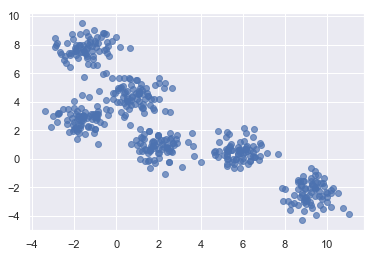

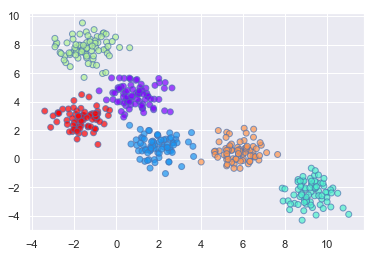

In [7]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import Birch

X, clusters = make_blobs(n_samples=450, centers=6, cluster_std=0.70, random_state=0)
plt.scatter(X[:,0], X[:,1], alpha=0.7, edgecolors='b')
plt.show()

brc = BIRCH(branching_factor=50, n_clusters=6, threshold=1.5)

labels = brc.get_labels(X)
plt.scatter(X[:,0], X[:,1], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b')
plt.show()

In [8]:
print(labels)

[5 5 1 2 0 0 3 0 2 3 1 5 5 4 2 3 4 5 4 1 0 1 5 1 3 4 5 4 4 4 3 5 3 5 3 2 4
 3 5 5 4 1 1 3 0 3 2 3 3 1 1 2 5 2 0 0 5 0 3 5 4 2 3 5 5 4 3 3 1 1 3 1 3 3
 2 1 4 2 2 4 3 5 3 0 2 1 3 5 1 4 1 3 1 4 0 3 5 5 2 0 2 3 2 4 2 0 0 1 4 2 1
 0 5 2 1 2 4 2 1 2 4 0 2 0 1 5 3 0 2 2 2 0 0 4 2 2 1 0 4 0 5 4 5 2 1 3 0 4
 1 2 3 0 2 5 2 5 1 1 1 3 3 5 4 2 2 4 5 5 0 4 2 2 0 3 4 2 2 1 5 4 3 2 2 4 4
 1 5 0 2 3 2 2 1 0 3 5 4 1 1 2 4 4 4 5 5 0 5 1 4 2 5 0 2 2 0 5 5 5 3 0 0 5
 4 0 3 4 4 4 3 0 1 5 5 0 1 0 2 3 0 0 5 3 0 4 0 4 0 1 5 1 5 0 3 2 5 2 1 1 0
 3 0 0 5 0 3 2 0 1 3 0 1 3 3 4 3 5 2 0 3 0 5 4 2 1 2 0 2 2 1 2 2 0 3 3 2 2
 2 1 4 5 1 0 3 1 0 3 5 4 0 4 1 0 3 5 3 4 5 3 4 4 3 3 3 4 4 5 4 3 1 1 4 1 4
 2 0 5 1 0 5 1 4 1 3 1 4 1 5 2 1 2 2 5 2 3 1 3 4 2 4 5 3 1 4 3 5 0 3 0 4 2
 3 0 4 5 4 1 5 0 5 3 5 2 4 1 1 0 3 3 3 2 2 3 1 1 0 1 4 3 0 2 3 3 5 4 1 4 0
 2 5 5 4 2 1 1 0 0 5 0 5 4 1 1 1 0 2 3 4 2 5 1 4 4 4 5 1 0 5 5 0 3 0 0 1 4
 0 4 5 1 4 0]
